In this notebook we want to find the ClinVar variants that are most likely to effect CTF. 
This are the chosen conditions: 

1. CDS SNPs. 
2. distance from domain <= 67 amino-acids
3. MFE z-score is in the top/bottom 5% of all scores in the ds. 
5. mfe change > 1.5


In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Utils_MDR1 import calc_windows_mfe, calc_mfe_per_position, mutate_cds_sequence, reverse_complement, colors
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
import math
import seaborn as sns
from typing import Tuple


Important note: mut_allele and ref_allele in the clinvar df are reported on the positive strand. 

## Functions

In [4]:
def get_z_and_dist(chr_position: int, gene_id: str, chr2cds: dict, gene_protein_dict: dict) -> Tuple[int, float, float, bool]:
    ''' For a specific genomic position, get its cds position, its z-score, 
    shortest distance from a domain and whether it is a valid position.
    '''
    try:
        protein_id = gene_protein_dict[gene_id] #get ENSP id
        data_file = pd.read_csv(f"../Results/AllGenes/domains_csvs/mfe_vertical_{protein_id}_z_scores_with_domain_dist.txt") #holds z-score and domain distance
        cds_position = chr2cds[gene_id, protein_id][chr_position - 1] + 1 #1-based cds pos
        zscore = data_file.loc[cds_position - 1, "z-score"]
        valid = data_file.loc[cds_position - 1, "good_position"]
        dist = data_file.loc[cds_position - 1, "shortest_dist_from_domain"]

    except:
        cds_position, zscore, valid, dist = None, None, None, None
        

    return(cds_position, zscore, dist, valid)


In [5]:
def get_delta_mfe(gene_id: str, cds_position: int, mut_allele: str, strand: int) -> float:
    '''
    Given the position of a variant in a gene, return the change in MFE caused by the variant
    '''

    # Get the CDS sequence
    genes_dict = pd.read_pickle(f"../Data/AllGenes/orthologs/cdna_dict/cdna_{gene_id}.pickle.gz")
    nt_CDS = genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #removing stop codon -> msa was on aas and ttanslated back, so no info on stop codons

    #get mfe profile of the original sequence
    mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
    mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

    #get mfe profile of the mutated sequence
    if strand == -1:
        mut_allele = reverse_complement(mut_allele) #mut_allele is on the positive strand. reverse if we need to
    nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, mut_allele) #mutate the sequence
    mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
    mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position
    
    delta_mfe = (mfe_positions_mut[0,cds_position - 1] - mfe_positions[0,cds_position - 1])

    return(delta_mfe)


In [10]:
def get_significant_positions(zscores_df: pd.DataFrame) -> pd.DataFrame:
    ''' 
    Get positions with significant z-scores for the CTF plot
    '''
    
    low_z = zscores_df["z-score"] < 0 #z-scores that are below the mean
    high_z = zscores_df["z-score"] > 0 #z-scores that are below the mean
    low_p = zscores_df["corrected p-value"] < 0.1 #z-scores with a p-value lower than 0.1 (could be high or low z-scores)
    good_pos = zscores_df["good_position"] == True #only z-scores at valid positions
    
    zscores_df["significantly_low_mfe"] = low_z & low_p & good_pos
    zscores_df["significantly_high_mfe"] = high_z & low_p & good_pos
    
    return(zscores_df)



In [12]:
def plot_v2_withcolumn(variant_name:str, cds_pos: int, mfe_scores_original: np.array, low_positions: np.array, high_positions: np.array, z_scores_vertical: pd.DataFrame, z_scores_column: pd.DataFrame) -> None:
    '''
    Plot the CTF model results 
    '''
    num_positions = mfe_scores_original.shape[0] #total number of positions in the CDS
    
    profile, = plt.plot(np.arange(num_positions), mfe_scores_original, c = "grey")

    vertic = plt.axvline(x = cds_pos, color = "royalblue")

    # Replace dots with vertical lines
    ymin, ymax = plt.ylim()
    for xi in low_positions:
        plt.vlines(xi, ymin, ymax, colors=colors[3], label = None)  # Draw a vertical line at each data point's x-coordinate
    for xi in high_positions:
        plt.vlines(xi, ymin, ymax, colors=colors[6], label = None)  

    proxy1 = plt.Line2D([0], [0], linestyle='none', color=colors[3], marker='_', markersize = 10)
    proxy2 = plt.Line2D([0], [0], linestyle='none', color=colors[6], marker='_', markersize = 10)

    plt.legend([profile, vertic, proxy1, proxy2],["Mean across orthologs", "Position of variant", "Conserved low MFE","Conserved high MFE"], framealpha=0.5, prop={'size': 12}, loc = "lower left")

    plt.xlim([cds_pos - 100, cds_pos + 100])
    

    plt.title(f"{variant_name}", size = 15)

    plt.xlabel("CDS position [nt]", size = 15)
    plt.ylabel("MFE [kcal/mol]", size = 15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim([ymin + 1, ymax - 1])
    
    plt.savefig(f'../MDR1/Figures/co_trans/{variant_name}_SMC1A.png', bbox_inches = "tight", dpi=500)

In [15]:
''' 

Plots and saves the MFE profiles of the original and mutated MDR1 CDS in the vicinity of a variant
"cds_pos_1base" - the positions of the mutations, relative to the CDS, 1-based. 
"mfe_positions" - the vector of mfe scores of the entire CDS. Each CDS position has one score. 
"mfe_positions_mutated" - same, but with the variant in "cds_pos_1base". 
"changed_from" - the original nucleotide in "cds_pos_1base"
"changed_to" - the nucleotide that is in "cds_pos_1base" after the variation. 
"pval" - in the notebook "p_vals_mfe.ipynb" we create randomomized sequences (the MDR1 CDS sequence with a single mutation), calculated the delta-mfe for the randomizations 
and obtained an empirical p-value. Here we retrieve it fore the plot. 

'''

def plot_mfe_change(cds_pos_1base: int, mfe_positions: np.array, mfe_positions_mutated: np.array, changed_from: str, changed_to: str, pval: float) -> None:
    
    plt.figure(figsize=(10, 6))

    x = np.arange(mfe_positions.shape[1]) + 1
    plt.plot(x, mfe_positions.T, label = f'{cds_pos_1base}:{changed_from}', c = 'slategrey')
    plt.plot(x, mfe_positions_mutated.T, label = f'{cds_pos_1base}:{changed_to}', c = 'red')
    delta = np.round((mfe_positions_mutated[0,cds_pos_1base - 1] - mfe_positions[0,cds_pos_1base - 1]),2)

    variant = f"{changed_from}{cds_pos_1base}{changed_to}"
    #plt.title(f"Effect of {variant} on the local MFE profile (delta = {delta}, p = {pval})")
    plt.title(f"{variant} (Delta = {delta}, p = {pval})", size=25)

    plt.xlabel("CDS position [nt]", size=25)
    plt.ylabel("MFE [kcal/mol]", size=25)
    plt.axvline(x = cds_pos_1base, color = 'royalblue', label = 'position of variant')
    plt.scatter(cds_pos_1base, mfe_positions.T[cds_pos_1base - 1], c = "slategrey", s = 20 )
    plt.scatter(cds_pos_1base, mfe_positions_mutated.T[cds_pos_1base - 1], c = "red", s = 20)

    plt.text(cds_pos_1base + 1, mfe_positions_mutated.T[cds_pos_1base - 1] , np.round(mfe_positions_mutated[0,cds_pos_1base - 1],2), size=13)
    plt.text(cds_pos_1base - 9, mfe_positions.T[cds_pos_1base - 1], np.round(mfe_positions[0,cds_pos_1base - 1],2), size=13)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend(prop={'size': 20})
    x_min = cds_pos_1base - 50
    x_max = cds_pos_1base + 50

    plt.xlim([x_min,x_max])
    plt.savefig(f'../MDR1/Figures/MFE/delta_mfe_{changed_from}{cds_pos_1base}{changed_to}_SMC1A.png', bbox_inches = "tight", dpi=500)

    plt.show()


## Main

In [6]:
''' Load the ClinVar df '''

clinvar_df = pd.read_pickle("../Data/ClinVar_processed_df.pickle")
clinvar_df = clinvar_df[clinvar_df["Variant_Type"] == "SNP"].copy() #keep only snps

#keep only cds variants (both synonymous and non-synonymous)
nonsyn = ~clinvar_df["Protein change"].isna()
syn = clinvar_df["Name"].apply(lambda x: "=" in x)
clinvar_df = clinvar_df[syn | nonsyn].copy()



In [7]:
clinvar_df.shape

(131231, 30)

In [9]:
# Create and write to a text file - all unique genes on Clinvar
with open('.../MDR1/Data/clinvar_genes_list.txt', 'w') as file:
    for gene in clinvar_df["Gene"].unique():
        file.write(gene + '\n')


In [31]:
''' Add the z-score and domain distance to each variant '''

#obtain ENSP ids and mapping of chromosome positions to cds positions
gene_protein_dict = pd.read_pickle("../Data/gene_protein_dict.pickle")
cds_to_chrom_dict = pd.read_pickle("../Data/cds_to_chrom_dict_with_protein_id.pickle")
chr2cds = {} 
for outer_key, inner_dict in cds_to_chrom_dict.items():
        reversed_inner = {value: key for key, value in inner_dict.items()}
        chr2cds[outer_key] = reversed_inner

#for each variant, get the zscores and distance from closest domain
clinvar_df[["cds_position", "zscore", "domain_distance", "valid"]] = clinvar_df.apply(lambda x: pd.Series(get_z_and_dist(x["Start_Position"], x["Gene stable ID"], chr2cds, gene_protein_dict)), axis=1)


In [32]:
# keep only variants in valid positions
clinvar_df = clinvar_df[clinvar_df["valid"] == True].copy()

In [33]:
clinvar_df.shape

(87083, 34)

#### get potentially ctf modifying variants

In [11]:
''' Decide on z-score threshold and remove variants accordingly '''
percentile_5 = clinvar_df['zscore'].quantile(0.05)
percentile_95 = clinvar_df['zscore'].quantile(0.95)

print(f"Chosen thresholds:\nbottom: {np.round(percentile_5,2)}, top: {np.round(percentile_95,2)}")

extreme_df = clinvar_df[(clinvar_df['zscore'] <= percentile_5) | (clinvar_df['zscore'] >= percentile_95)].copy()


Chosen thresholds:
bottom: -6.26, top: 4.55


In [12]:
''' Remove variants that are far from a domain '''
extreme_df = extreme_df[extreme_df["domain_distance"] <= 67].copy()

In [13]:
extreme_df.shape

(5562, 34)

In [16]:
''' Calculate delta mfe. use batching and parallel computing '''

def process_batch(batch, func):
    results = []
    for _, row in batch.iterrows():
        delta_mfe = func(row['Gene stable ID'], int(row['cds_position']), row['mut_allele'], row['Strand']) #get the delta_mfe of a single variant
        results.append(delta_mfe)
    return results

def parallel_apply_with_batching(df, func, batch_size = 70):
    num_cores = cpu_count()
    
    # Split the DataFrame into batches
    num_batches = math.ceil(len(df) / batch_size)
    batches = np.array_split(df, num_batches)
    
    # Create a partial function with the custom function
    partial_process = partial(process_batch, func=func)
    
    # Process batches in parallel
    with Pool(num_cores) as pool:
        results = pool.map(partial_process, batches)
    
    # Flatten the results
    flat_results = [item for sublist in results for item in sublist]
    
    return flat_results

# Apply the function in parallel with batching
delta_mfe_results = parallel_apply_with_batching(extreme_df, get_delta_mfe)

# Add the results to the DataFrame
extreme_df['delta_mfe'] = delta_mfe_results

In [17]:
'''keep only those where |delta| > 1.5 and disrupts the conservation ''' 

delta_threshold = 1.5

fast_variants = (extreme_df["zscore"] < 0) & (extreme_df["delta_mfe"] >= delta_threshold)
slow_variants = (extreme_df["zscore"] > 0) & (extreme_df["delta_mfe"] <= -delta_threshold)

extreme_df = extreme_df[fast_variants | slow_variants].copy()


## Enrichment of pathogenic variants

In [2]:
extreme_df = extreme_df[~extreme_df["Name"].apply(lambda x: "Ter" in x)] #remove variants that cause early translation stopping

extreme_df_save = extreme_df[["mut_id", "Chromosome", "Gene", "Condition(s)", "Clinical significance", "VariationID", "dbSNP ID", 
            "domain_distance", "zscore", "delta_mfe", "Transcript stable ID", "Strand", "Gene stable ID"]].sort_values(by = "delta_mfe")
#save the final df - this is what we have in Supporting information file 2
extreme_df_save.to_csv("../Results/AllGenes/specific_muts/extreme_mutations_ClinVar/extreme_df_clinvar.tsv", sep='\t', index=False)


## Find interesting specific cases


In [25]:
''' Let's focus on synonymous variants that are known to be related to a specific disease '''

syn = extreme_df["Name"].apply(lambda x: "=" in x) # keep synonymous variants
cond = extreme_df["Condition(s)"] != "not provided" #remove those who are not related to a specific condition
not_in_dbsnp = extreme_df["dbSNP ID"].isna() #remove those in dbSNP (more common in the population

extreme_df[syn & cond & not_in_dbsnp].sort_values(by = "delta_mfe", ascending = False)


,Unnamed: 0,Name,Gene,Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,...,ref_allele,mut_allele,Variant_Type,mut_id,passed_assertion,cds_position,zscore,domain_distance,valid,delta_mfe
517,305469,NM_006306.4(SMC1A):c.1923G>A (p.Leu641=),SMC1A,NaN,Congenital muscular hypertrophy-cerebral syndrome,"Benign(Last reviewed: Jul 12, 2022)","criteria provided, single submitter",VCV001648460,X,53432312,...,C,T,SNP,SMC1A:chrX:53405380:C:T,True,1923.0,-11.698822,0.0,True,4.376923
465,283364,NM_004975.4(KCNB1):c.1356T>C (p.Asp452=),KCNB1,NaN,"Developmental and epileptic encephalopathy, 26...","Benign(Last reviewed: Mar 19, 2020)","criteria provided, multiple submitters, no con...",VCV001169459,20,47990741,...,A,G,SNP,KCNB1:chr20:49374204:A:G,True,1356.0,-8.019349,29.0,True,3.358974
516,305282,NM_001111125.3(IQSEC2):c.2931G>A (p.Gln977=),IQSEC2,NaN,"Intellectual disability, X-linked 1","Benign(Last reviewed: Mar 29, 2022)","criteria provided, single submitter",VCV001167673,X,53271050,...,C,T,SNP,IQSEC2:chrX:53241868:C:T,True,2931.0,-6.755096,0.0,True,2.212821
302,184193,NM_005276.4(GPD1):c.1017C>T (p.Ile339=),GPD1,NaN,not provided|Transient infantile hypertriglyce...,"Benign(Last reviewed: Nov 4, 2022)","criteria provided, multiple submitters, no con...",VCV001285304,12.0,50503269,...,C,T,SNP,GPD1:chr12:50109486:C:T,True,1017.0,-8.290085,0.0,True,2.045161
532,311281,NM_000276.4(OCRL):c.1128G>T (p.Leu376=),OCRL,NaN,Lowe syndrome,"Benign(Last reviewed: Sep 26, 2022)","criteria provided, single submitter",VCV002056878,X,128696647,...,G,T,SNP,OCRL:chrX:129562670:G:T,True,1128.0,-7.021001,0.0,True,1.794872
200,121211,NM_001550.4(IFRD1):c.1242G>A (p.Thr414=),IFRD1,NaN,not specified,Benign,no assertion criteria provided,VCV001284599,7,112112892,...,G,A,SNP,IFRD1:chr7:112472837:G:A,True,1242.0,-12.576724,0.0,True,1.753846
508,302318,NM_000397.4(CYBB):c.1701G>A (p.Lys567=),CYBB,NaN,"Granulomatous disease, chronic, X-linked","Benign(Last reviewed: Oct 16, 2022)","criteria provided, single submitter",VCV001164652,X,37670158,...,G,A,SNP,CYBB:chrX:37810905:G:A,True,1701.0,-7.312779,17.0,True,1.700000
195,119779,NM_004444.5(EPHB4):c.2931G>A (p.Pro977=),EPHB4,NaN,Cardiovascular phenotype,"Benign(Last reviewed: Nov 4, 2020)","criteria provided, single submitter",VCV001797826,7,100401116,...,C,T,SNP,EPHB4:chr7:100803494:C:T,True,2931.0,-7.180058,4.0,True,1.564516
16,5309,NM_016011.5(MECR):c.597A>G (p.Ala199=),MECR,NaN,"Dystonia, childhood-onset, with optic atrophy ...","Benign(Last reviewed: Nov 4, 2022)","criteria provided, multiple submitters, no con...",VCV001251778,1,29529699,...,T,C,SNP,MECR:chr1:29203187:T:C,True,597.0,4.847460,0.0,True,-2.197436
533,311346,NM_000276.4(OCRL):c.2658T>A (p.Arg886=),OCRL,NaN,Lowe syndrome,"Benign(Last reviewed: Jun 14, 2022)","criteria provided, single submitter",VCV002075084,X,128724199,...,T,A,SNP,OCRL:chrX:129590222:T:A,True,2658.0,8.621197,0.0,True,-2.215385


## NM_006306.4(SMC1A):c.1923G>A (p.Leu641=)
- in dbSNP - but not common: rs782123095	0.00008
- in a domain - SMCs flexible hinge domain
- is proximal to exon 12 border. Doesn't affect splicing according to spliceAI. 
- low nucleotide conservation... 
- in a conserved low MFE region - and creates a large change in mfe (need to check significance of the change). 



### Plot CTF model results for SMC1A variant - Figure 11b

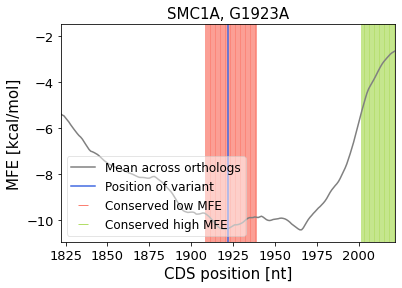

In [8]:
''' Check the MFE conservation surrounding it '''

gene = "ENSG00000072501"

''' Get the mfe profiles of the original MDR1 gene '''
original = pd.read_pickle(f"../Data/AllGenes/mfe/mfe_scores/original/{gene}.pickle.gz")

''' Get the positions with the significantly low/high z-scores '''
#z-scores of all MDR1 cds positions
z_scores_vertical = pd.read_pickle(f"../Results/AllGenes/mfe/z-scores/{gene}_vertical.pickle")
z_scores_column = pd.read_pickle(f"../Results/AllGenes/mfe/z-scores/{gene}_column.pickle")

#add to each df two boolian columns indicating wether the position has significantly (p<0.1) low or high mfe
z_scores_vertical = get_significant_positions(z_scores_vertical)
z_scores_column = get_significant_positions(z_scores_column)

#get the positions for which there is concensus among vertical and column methods
low_mfe = (z_scores_vertical["significantly_low_mfe"] & z_scores_column["significantly_low_mfe"]).replace({True: 1, False: 0})
high_mfe = (z_scores_vertical["significantly_high_mfe"] & z_scores_column["significantly_high_mfe"]).replace({True: 1, False: 0})

low_positions = np.where(low_mfe == 1)[0] #the CDS positions with significantly low z-scores
high_positions = np.where(high_mfe == 1)[0]#the CDS positions with significantly high z-scores

variant_name = "SMC1A, G1923A"
cds_pos = 1923 - 1 #0-based
plot_v2_withcolumn(variant_name, cds_pos, original, low_positions, high_positions, z_scores_vertical, z_scores_column)


In [27]:
''' get affects on CAI and tAI '''

cai_weights = pd.read_pickle("../MDR1/Data/homo_sapiens_CAI.pickle")
tai_weights = pd.read_pickle("../MDR1/Data/tAI_weights/tAI_human_general.pickle")

codon_before = "CTG"
codon_after = "CTA"

print(f"CAI before: {cai_weights[codon_before]}")
print(f"CAI after: {cai_weights[codon_after]}")
print(f"CAI difference: {cai_weights[codon_after] - cai_weights[codon_before]}")

print(f"tAI before: {tai_weights[codon_before]}")
print(f"tAI after: {tai_weights[codon_after]}")
print(f"tAI difference: {tai_weights[codon_after] - tai_weights[codon_before]}")


CAI before: 1.0
CAI after: 0.18772117325733287
CAI difference: -0.8122788267426672
tAI before: 0.334963
tAI after: 0.091724
tAI difference: -0.243239


### Plot MFE change for the SMC1A variant - Figure 11c

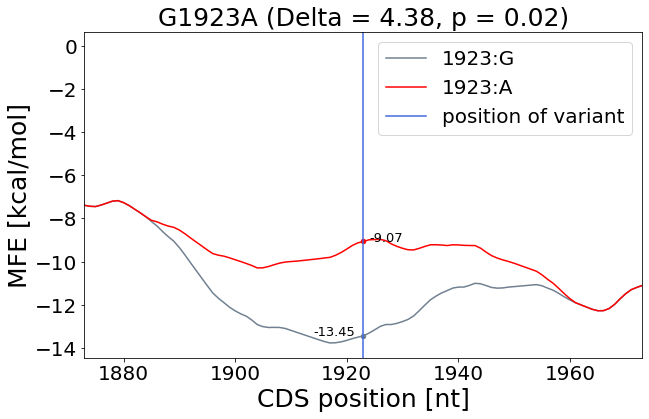

In [16]:
gene = "ENSG00000072501" #MDR1
genes_dict = pd.read_pickle(f"../Data/AllGenes/orthologs/cdna_dict/cdna_{gene}.pickle.gz")
nt_CDS= genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #removing stop codon -> msa was on aas and ttanslated back, so no info on stop codons

cds_position = 1923 #1-based
change_to = "A"
change_from = "G"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = 0.02 #calculated in "p_vals_mfe_SMC1A.ipynb" 

#plot
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


## Meta-data plots for ClinVar extreme CTF mutations - Figure S7


In [4]:
extreme_df_save = pd.read_csv("../Results/extreme_df_clinvar.tsv", sep = "\t")
extreme_df_save.head()

,mut_id,Chromosome,Gene,Condition(s),Clinical significance,VariationID,dbSNP ID,domain_distance,zscore,delta_mfe,Transcript stable ID,Strand,Gene stable ID
0,GALNS:chr16:88835791:G:C,chr16,GALNS,"not specified|Mucopolysaccharidosis, MPS-IV-A",Benign,93183,rs34745339,0.0,5.190851,-4.179487,ENST00000268695,-1,ENSG00000141012
1,ACVR1C:chr2:157544593:T:C,chr2,ACVR1C,not provided,Benign,783343,rs6746788,0.0,5.348304,-4.025641,ENST00000243349,-1,ENSG00000123612
2,PLCB4:chr20:9409086:A:G,chr20,PLCB4,Auriculocondylar syndrome 1,Pathogenic,31637,rs397514480,0.0,5.700128,-3.951282,ENST00000378473,1,ENSG00000101333
3,PPP1R10:chr6:30608824:T:C,chr6,PPP1R10,not provided,Benign,712614,rs34208587,0.0,6.000068,-3.748718,ENST00000376511,-1,ENSG00000204569
4,YWHAG:chr7:76329866:T:C,chr7,YWHAG,not provided,Benign,1536619,NaN,0.0,4.750005,-3.646154,ENST00000307630,-1,ENSG00000170027


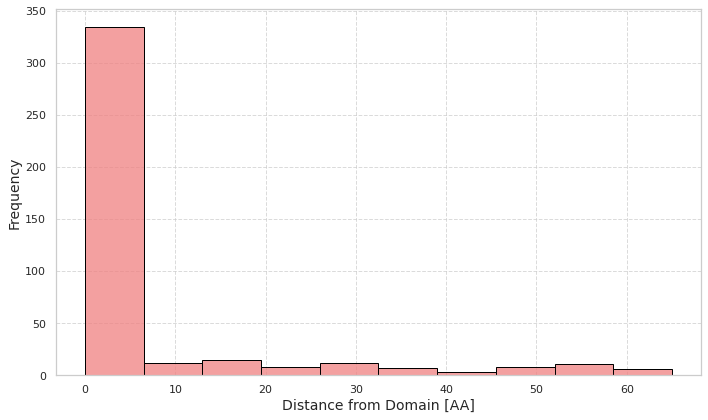

In [6]:
''' domain dist distribution (figure S7b)  '''

# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create the histogram with enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    extreme_df_save["domain_distance"], 
    bins=10,  # Number of bins
    color="lightcoral",  # Set bar color
    edgecolor="black"  # Add black edges to the bars
)

# Customize labels and title
plt.xlabel("Distance from Domain [AA]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Enhance the grid and plot layout
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig('../MDR1/Figures/folding_general/domain_distance_distribution_clinvar.png', bbox_inches = "tight", dpi=500)

plt.show()




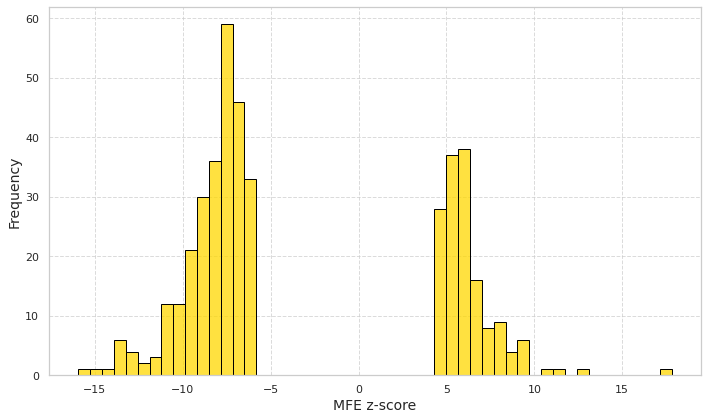

In [5]:
'''  MFE z-score distribution (Figure S7a) '''

# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create the histogram with enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    extreme_df_save["zscore"], 
    bins=50,  # Number of bins
    color="gold",  # Set bar color
    edgecolor="black"  # Add black edges to the bars
)

# Customize labels and title
plt.xlabel("MFE z-score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Enhance the grid and plot layout
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig('../MDR1/Figures/folding_general/zscore_distribution_clinvar.png', bbox_inches = "tight", dpi=500)

plt.show()




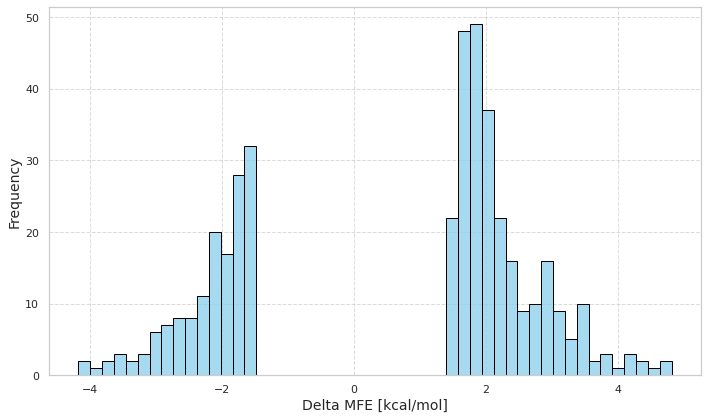

In [46]:
''' delta MFE distribution (Figure 7c) '''

# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create the histogram with enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    extreme_df_save["delta_mfe"], 
    bins=50,  # Number of bins
    color="skyblue",  # Set bar color
    edgecolor="black"  # Add black edges to the bars
)

# Customize labels and title
plt.xlabel("Delta MFE [kcal/mol]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Enhance the grid and plot layout
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig('../MDR1/Figures/folding_general/delta_mfe_distribution_clinvar.png', bbox_inches = "tight", dpi=500)

plt.show()




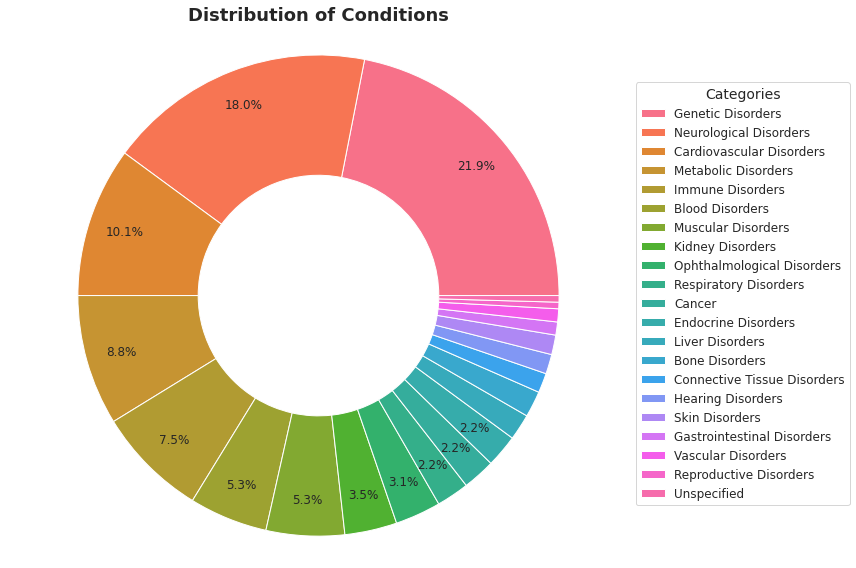

In [39]:
''' Conditions '''

categories = pd.read_csv("../Results/Condition Categories.csv", sep = ",") #the data was created in "check_enrichment_clinvar_CTF.ipynb"

# Count the occurrences of each category and sort them
category_counts = categories['Category'].value_counts()

# Set the seaborn style for a more aesthetic look
sns.set_style("whitegrid")

# Create a color palette for 20 categories
colors = sns.color_palette("husl", n_colors=len(category_counts))

# Create the pie chart
plt.figure(figsize=(12, 8))  # Increased figure size
wedges, texts, autotexts = plt.pie(category_counts.values, 
                                   colors=colors,
                                   autopct=lambda pct: f'{pct:.1f}%' if pct > 2 else '',
                                   pctdistance=0.85, 
                                   wedgeprops=dict(width=0.5, edgecolor='white'),
                                   textprops={'fontsize': 12})  # Increased font size for percentages

# Increase font size for percentage labels
for autotext in autotexts:
    autotext.set_fontsize(12)

# Add a title
plt.title("Distribution of Conditions", fontsize=18, fontweight='bold')

# Create legend with increased font size
plt.legend(wedges, category_counts.index,
           title="Categories",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=12,  # Increased font size for category names
           title_fontsize=14)  # Increased font size for legend title

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

plt.savefig(f'../MDR1/Figures/folding_general/category_distribution_clinvar.png', bbox_inches = "tight", dpi=500)

# Show the plot
plt.show()
